In [1]:
import pandas as pd
import h5py
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import datetime as dt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import joblib

In [2]:
with pd.HDFStore('daily_combined_data.hdf') as store:
    daily_keys = [key[1:] for key in store.keys()]

# keys = ['hydro_07ED002', 'hydro_07EF002', 'hydro_07EF003', 'hydro_08GB013', 'hydro_08HB082', 'hydro_08HD025', 'hydro_08JA022', 'hydro_08JA023', 'hydro_08JA027', 'hydro_08LC018', 'hydro_08LC041', 'hydro_08ME017', 'hydro_08MH141', 'hydro_08MH148', 'hydro_08MH149', 'hydro_08MH167', 'hydro_08NB017', 'hydro_08ND017', 'hydro_08NE102', 'hydro_08NE103', 'hydro_08NE104', 'hydro_08NE107', 'hydro_08NH064', 'hydro_08NH067', 'hydro_08NH127', 'hydro_08NM213', 'hydro_08NM234']
# for key in keys:
#         my_hdf = pd.read_hdf('combined_data.hdf', key=key)
#         print(key, len(my_hdf), len(my_hdf.dropna()))

In [3]:
def plot_errors(model, X_valid, y_valid, output_filename):
    plt.hist(y_valid - model.predict(X_valid), bins=100)
    plt.savefig('models/errors_{}.png'.format(output_filename))
    plt.close()

def plot_model(df, model, output_filename, filter_month=None):
    if filter_month:
        df = df[df['month'] == filter_month]
    # real values in blue, predicted values in red
    plt.plot(df['date'], df['water_level'], 'b.', alpha=0.5)
    plt.scatter(df['date'], model.predict(df[X_COLUMNS]), s=1, alpha=0.5, c='r')
    plt.show()
    plt.savefig('models/predict_{}.png'.format(output_filename))
    plt.close()
    
def plot_df_vals(df):
    scaled_df = pd.DataFrame(StandardScaler().fit_transform(df))
    scaled_df.columns = df.columns
    scaled_df.index = df.index
    plt.plot(scaled_df.index, scaled_df['water_level'], c= 'b')
    plt.plot(scaled_df.index, scaled_df['precip'], c= 'r')
    plt.plot(scaled_df.index, scaled_df['rain'], c= 'yellow')
    plt.plot(scaled_df.index, scaled_df['mean_temp'], c='g')
    plt.plot(scaled_df.index, scaled_df['snow_precip'], c='aqua')
    plt.plot(scaled_df.index, scaled_df['snow_on_grnd'], c='magenta')
    
def model_scores(model, X_train, X_valid, y_train, y_valid):
    return {'train_score': model.score(X_train, y_train), 'valid_score': model.score(X_valid, y_valid)}

def train_and_generate_model(X_train, y_train, C, n_components, scaler):
    imputer = SimpleImputer()
    model = make_pipeline(
        imputer,
        scaler,
        PCA(n_components=n_components), # assume we have some kind of time, precip and temp dimensionality
        SVR(C=C, gamma='scale')
    )
    model.fit(X_train, y_train)
    return model

def prepare_df(df):
    df['date'] = df.index.map(dt.datetime.toordinal)
    y_column = 'water_level'
    X = df[X_COLUMNS]
    y = df['water_level'].values
    return (X, y)

In [4]:
def create_models(key,df=None, filter_month=None, show_plot=False, n_components=5, C=100, scaler=MinMaxScaler()):
    if df is None:
        df = pd.read_hdf('daily_combined_data.hdf', key=key).sort_index().dropna()
    X, y = prepare_df(df)
    
    if len(df) == 0:
        return None
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)

    model = train_and_generate_model(X_train, y_train, C=C, n_components=n_components, scaler=scaler)
    
    if show_plot:
        plot_model(df, model, key, filter_month)
    if SAVE_MODELS:
        joblib.dump(model, 'models/model-{}.pckl'.format(key))
        
    return model, model_scores(model, X_train, X_valid, y_train, y_valid)

In [10]:
def PCA_test(key, daily=True):
    filename = 'daily_combined_data.hdf' if daily else 'monthly_combined_data.hdf'

    df = pd.read_hdf(filename, key=key).sort_index().dropna()
    for i in range(2,8):
        print(key, i, create_models(key, df=df, n_components=i)[1])
    print()

In [11]:
def SVR_test(key, daily=True):
    filename = 'daily_combined_data.hdf' if daily else 'monthly_combined_data.hdf'

    df = pd.read_hdf(filename, key=key).sort_index().dropna()
    for i in range(-3,3):
        print(key, i, create_models(key, df=df, C=10**i)[1])
    print()

In [16]:
def Scaler_test(key, daily=True):
    filename = 'daily_combined_data.hdf' if daily else 'monthly_combined_data.hdf'

    df = pd.read_hdf(filename, key=key).sort_index().dropna()
    print(key, 'standard', create_models(key, df=df, scaler=StandardScaler())[1])
    print(key, 'minmax', create_models(key, df=df, scaler=MinMaxScaler())[1])
    print(key, 'robust', create_models(key, df=df, scaler=RobustScaler())[1])
    print()

In [5]:
SAVE_MODELS = False
X_COLUMNS = ['date','year', 'month', 'rain', 'precip', 'mean_temp', 'snow_on_grnd', 'snow_precip']

In [9]:
# test best components. 5 looks pretty good
for key in daily_keys:
    PCA_test(key)

hydro_07ED002 2 {'valid_score': 0.830528927240479, 'train_score': 0.8262663286565196}
hydro_07ED002 3 {'valid_score': 0.8636988092045371, 'train_score': 0.8776852748180174}
hydro_07ED002 4 {'valid_score': 0.8518633280684156, 'train_score': 0.8766588703583362}
hydro_07ED002 5 {'valid_score': 0.8866558532401345, 'train_score': 0.8901397608581436}


KeyboardInterrupt: 

In [12]:
# test best C value. 10e2 looks good, in terms of time/accuraccy tradeoff
for key in daily_keys:
    SVR_test(key)

hydro_07ED002 -3 {'valid_score': 0.01556064627634812, 'train_score': 0.04952207429242872}
hydro_07ED002 -2 {'valid_score': 0.4371589944647123, 'train_score': 0.4387812948460876}
hydro_07ED002 -1 {'valid_score': 0.7521754856204531, 'train_score': 0.7391990739599132}
hydro_07ED002 0 {'valid_score': 0.8241445679938778, 'train_score': 0.8444386754569418}
hydro_07ED002 1 {'valid_score': 0.8554484412319857, 'train_score': 0.8698366312179368}
hydro_07ED002 2 {'valid_score': 0.8797528005415622, 'train_score': 0.8878644125010294}

hydro_08EB003 -3 {'valid_score': 0.0389788177207564, 'train_score': 0.0506248337940175}
hydro_08EB003 -2 {'valid_score': 0.3958574855491915, 'train_score': 0.4035667618285603}
hydro_08EB003 -1 {'valid_score': 0.5792683924618197, 'train_score': 0.5863176263587596}
hydro_08EB003 0 {'valid_score': 0.6945721078432849, 'train_score': 0.7099907423739956}


KeyboardInterrupt: 

In [17]:
# test best scaler. minmax looks the best
for key in daily_keys:
    Scaler_test(key)

hydro_07ED002 standard {'valid_score': 0.8262012761590404, 'train_score': 0.8394327646723538}
hydro_07ED002 minmax {'valid_score': 0.8846587050347617, 'train_score': 0.8881690788831351}
hydro_07ED002 robust {'valid_score': 0.3595546333930879, 'train_score': 0.37426049109865367}

hydro_08EB003 standard {'valid_score': 0.6965641377423422, 'train_score': 0.7409140441394608}
hydro_08EB003 minmax {'valid_score': 0.7997171819966551, 'train_score': 0.7911470100856524}
hydro_08EB003 robust {'valid_score': 0.4585153195401948, 'train_score': 0.44883366447070017}



KeyboardInterrupt: 

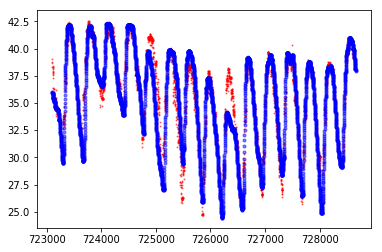

hydro_07ED002 {'valid_score': 0.8731328089640906, 'train_score': 0.8908204170412896}


KeyboardInterrupt: 

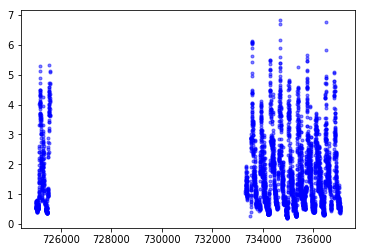

In [19]:
# daily models
for key in daily_keys:
    model, scores = create_models(key, show_plot=True)
    print(key, scores)
    if SAVE_MODELS:
        joblib.dump(model, 'models/model-{}.pckl'.format(key))
    #plot_errors(model, X_valid, y_valid, key)

In [20]:
pd.read_hdf('monthly_combined_data.hdf', key='hydro_07ED002')

,year,month,monthly_water_mean,monthly_water_total,monthly_water_min,monthly_water_max,min_water_day,max_water_day,mean_max_temp,mean_min_temp,mean_temp,month_min_temp,month_max_temp,rain,total_snow,precip,remaining_snow
1980-11,1980,11,35.266998,1058.017,35.060001,35.474998,30.0,1.0,2.400000,-3.700000,-0.700000,-20.000000,11.600000,44.000000,372.000008,80.400002,230.000000
1980-12,1980,12,34.630001,1073.530,34.465000,35.033001,24.0,1.0,-8.100000,-15.800000,-12.000000,-28.900000,8.300000,20.200001,1064.000015,123.000000,300.000000
1981-01,1981,1,34.415001,1066.880,34.332001,34.507999,31.0,1.0,-1.900000,-8.400000,-5.200000,-18.600000,9.800000,5.200000,213.999996,24.400000,310.000000
1981-02,1981,2,33.712002,943.939,33.200001,34.313000,28.0,1.0,-2.200000,-9.200000,-5.700000,-29.100000,8.900000,6.800000,316.000004,37.000000,210.000000
1981-03,1981,3,32.095001,994.931,31.059000,33.140999,31.0,1.0,5.800000,-7.100000,-0.700000,-17.500000,11.200000,3.000000,68.000002,9.800000,20.000000
1981-04,1981,4,30.073999,902.211,29.438999,30.985001,27.0,1.0,6.500000,-3.100000,1.700000,-15.100000,17.700001,20.700001,605.999985,78.500000,0.000000
1981-05,1981,5,31.461000,975.305,29.584999,35.396999,1.0,31.0,17.600000,3.400000,10.500000,-4.600000,23.799999,49.799999,0.000000,49.799999,0.000000
1981-06,1981,6,38.546001,1156.372,35.738998,40.522999,1.0,30.0,17.000000,4.700000,10.900000,-2.100000,22.600000,82.800003,0.000000,82.800003,0.000000
1981-07,1981,7,41.604000,1289.728,40.611000,42.115002,1.0,30.0,23.299999,8.300000,15.800000,0.200000,31.500000,24.200001,0.000000,24.200001,0.000000
1981-08,1981,8,42.119999,1305.727,42.067001,42.181999,3.0,12.0,25.000000,7.000000,16.000000,1.500000,34.200001,9.000000,0.000000,9.000000,0.000000


In [ ]:
# monthly groupby, accuracy suffers from lack of datapoints
for key in keys:
    df = pd.read_hdf('combined_data.hdf', key=key).sort_index()
    sums = df[['year', 'month', 'rain', 'precip', 'snow_precip']].groupby(['year', 'month']).sum()
    avgs = df[['year', 'month', 'water_level', 'snow_on_grnd', 'max_temp', 'mean_temp', 'min_temp']].groupby(['year', 'month']).mean()
    monthly_df = sums.join(avgs).reset_index()
    monthly_df.index = monthly_df.apply(lambda x: dt.date(year=int(x['year']), month=int(x['month']), day=1), axis=1)
    print(create_models(key, df=monthly_df, show_plot=True)[1])

In [ ]:
# k1 = 5.0**2 * RBF(length_scale=3.0) *  ExpSineSquared(length_scale=1.3, periodicity=1.0)  # long term smooth rising trend
#k_years = 10**2 * RBF(length_scale=3.0) * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# k4 = 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=3**2)  # noise terms
#k = k_years


In [ ]:
# model notes
"""
drought-year outlier handling needs work
check for distribution along month? strong comp
coquitlam lake??? snowfall
compare models when training on monthly subsets of the data
group into months and then train models5
"""

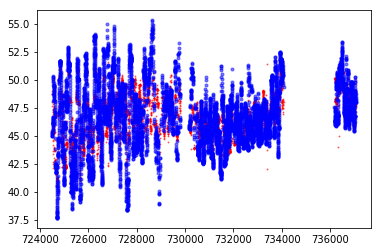

{'train_score': 0.4797322471499271, 'valid_score': 0.47880386054046925}

In [127]:
# plot a specific month for a model
create_models('hydro_08MH149', show_plot=True)[1]

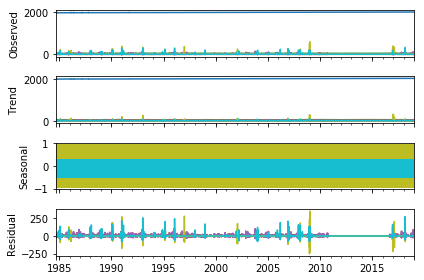

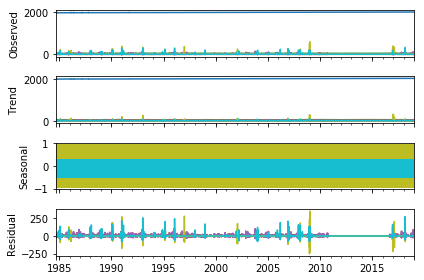

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_hdf('combined_data.hdf', key='hydro_08MH149').sort_index()
X = df.asfreq('D')
imputed_df = pd.DataFrame(SimpleImputer().fit_transform(X), columns=X.columns, index=X.index)

seasonal_decompose(imputed_df).plot() #???

In [4]:
from sklearn.cluster import KMeans

In [245]:
df = pd.read_csv('52-daily.csv').set_index('Date/Time')#.groupby(['Month', 'Day']).count()

In [223]:
df

,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
Date/Time,,,,,,,,,,
1991-01-01,1991,1,1,7.3625,3.479167,5.45,10.20,0.0,10.200000,0.0
1991-01-02,1991,1,2,7.3625,3.479167,5.45,0.00,0.0,0.000000,0.0
1991-01-03,1991,1,3,7.3625,3.479167,5.45,0.00,0.0,0.000000,0.0
1991-01-04,1991,1,4,7.3625,3.479167,5.45,0.00,0.0,0.000000,0.0
1991-01-05,1991,1,5,7.3625,3.479167,5.45,0.00,0.0,0.000000,0.0
1991-01-06,1991,1,6,7.3625,3.479167,5.45,0.00,9.0,9.000000,0.0
1991-01-07,1991,1,7,7.3625,3.479167,5.45,0.20,5.2,5.400000,0.0
1991-01-08,1991,1,8,7.3625,3.479167,5.45,18.00,2.2,20.200001,0.0
1991-01-09,1991,1,9,7.3625,3.479167,5.45,0.00,0.0,0.000000,0.0
